# Examples of utils provided by ReGraph's neo4j module

In [1]:
import networkx as nx

from regraph import Rule, plot_rule
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

## Initializing Neo4j graph

0. When installing neo4j you will be asked to choose login/password for you dbs (here its "neo4j"/"admin"), if you choose other -- change in the cell below.
1. To start neo4j server run `sudo service neo4j start`
2. Check status by running `sudo service neo4j status`. Here you can check the _bolt_ port, change the cell below if different from 7687
3. You can query the db by using the neo4j browser, the address can be found also in the result of 'status', e.g. "Remote interface available at http://localhost:7474/".

In [2]:
# initialize the neo4j driver, wrappped into Neo4jGraph object
g = Neo4jGraph(uri="bolt://localhost:7687", user="neo4j", password="admin")

In [3]:
# here we clear the db
res = g.clear()

In [4]:
nodes = [
    ("a", {"name": "Jack", "age": 23, "hobby": {"hiking", "music"}}), 
    ("b", {"name": "Bob", "age": 24, "hobby": {"sport", "music"}}),
    "c", "d", "e", "f"
]
edges = [
    ("a", "b", {"type": {"friends", "colleagues"}}), 
    ("d", "b"), 
    ("a", "c"),
    ("e", "a"), 
    ("f", "d")
]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

## Primitive operations on Neo4j graph

In [5]:
g.add_node("x", {"name": "Roberto"})

In [6]:
g.add_edge("x", "c", {"type": {"friends", "colleagues"}, "since": 1993})

In [7]:
g.nodes()

['a', 'b', 'c', 'e', 'f', 'd', 'x']

In [8]:
g.edges()

[('e', 'a'), ('d', 'b'), ('a', 'b'), ('x', 'c'), ('a', 'c'), ('f', 'd')]

In [9]:
res_clone_1 = g.clone_node('a')
print("Created clone by the name: ", res_clone_1)

Created clone by the name:  a1


In [10]:
res_clone_1 = g.clone_node('a', ignore_naming=True)
print("Created clone by the name: ", res_clone_1)

Created clone by the name:  10708557


In [11]:
res_clone_2 = g.clone_node('a', 'a_clone')
print("Created clone by the name: ", res_clone_2)

Created clone by the name:  a_clone


In [12]:
res_merge = g.merge_nodes(["a", "b"])

In [13]:
res_merge

'a_b'

## Rewriting Neo4j graph

### 1. Create an SqPO rewriting rule

In [14]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y", "z"])
pattern.add_edges_from([("y", "x"), ("y", "z"), ("z", "z")])

In [15]:
rule = Rule.from_transform(pattern)
clone_name1, _ = rule.inject_clone_node("y")
clone_name2, _ = rule.inject_clone_node("y")
rule.inject_remove_edge(clone_name2, "z")
rule.inject_remove_node("x")
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "z")

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


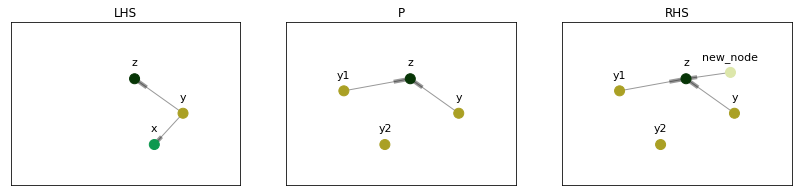

In [16]:
plot_rule(rule)

In [17]:
instances = g.find_matching(pattern)
print("Instances: ", instances)

Instances:  [{'x': 'a_clone', 'y': 'e', 'z': 'a_b'}, {'x': '10708557', 'y': 'e', 'z': 'a_b'}, {'x': 'a1', 'y': 'e', 'z': 'a_b'}]


In [18]:
rhs_g = g.rewrite(rule, instances[0])
print("\n\nRewriting rule to commands: \n")
print(rule.to_commands())



Rewriting rule to commands: 

CLONE y AS y1.
CLONE y AS y2.
DELETE_NODE x.
DELETE_EDGE y2 z.
ADD_NODE new_node {}.
ADD_EDGE new_node z {}.



In [19]:
rhs_g

{'new_node': '10708562',
 'y': 'e',
 'y1': '10708561',
 'y2': '10708588',
 'z': 'a_b'}